# Accident Severity Prediction – Montréal

This notebook analyzes road accident data from Montréal to predict accident severity.
The dataset is highly imbalanced, so the focus is on proper evaluation using
cross-validation, appropriate metrics, and threshold tuning rather than accuracy alone.

The project includes:
- Exploratory data analysis (EDA)
- Multiple classification models
- Handling class imbalance
- Model and threshold selection using cross-validation

## Data loading and initial inspection

In [1]:
# Import libraries and set up environment
import pandas as pd # For data manipulation
import numpy as np # For numerical operations
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Relative path to the dataset
DATA_PATH = "data/collisions_routieres.csv"

# Check if dataset exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        "Dataset not found.\n"
        "Please download the Montréal collision dataset and place it in:\n"
        "data/collisions_routieres.csv"
    )

# Load dataset
df = pd.read_csv(DATA_PATH)

In [4]:
# Display the first few rows
print(df.head())

           NO_SEQ_COLL JR_SEMN_ACCDN    DT_ACCDN  CD_MUNCP  NO_CIVIQ_ACCDN  \
0      SPVM _ 2012 _ 1            ME  2012/02/01   66102.0          3501.0   
1     SPVM _ 2012 _ 10            MA  2012/01/03   66023.0             NaN   
2    SPVM _ 2012 _ 100            VE  2012/02/24   66023.0             NaN   
3   SPVM _ 2012 _ 1000            JE  2012/10/11   66142.0         11800.0   
4  SPVM _ 2012 _ 10000            DI  2012/04/22   66023.0            38.0   

  SFX_NO_CIVIQ_ACCDN  BORNE_KM_ACCDN          RUE_ACCDN  TP_REPRR_ACCDN  \
0                NaN             NaN         ST CHARLES             2.0   
1                NaN             NaN  TERR VILLE DE MTL             NaN   
2                NaN             NaN     JACQUES BIZARD             1.0   
3                NaN             NaN       BD SALABERRY             NaN   
4                NaN             NaN     PL DU COMMERCE             NaN   

  ACCDN_PRES_DE  ...  NB_VICTIMES_VELO  VITESSE_AUTOR         LOC_X  \
0        

In [7]:
# Check dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218272 entries, 0 to 218271
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NO_SEQ_COLL                  218272 non-null  object 
 1   JR_SEMN_ACCDN                218272 non-null  object 
 2   DT_ACCDN                     218272 non-null  object 
 3   CD_MUNCP                     218265 non-null  float64
 4   NO_CIVIQ_ACCDN               93491 non-null   float64
 5   SFX_NO_CIVIQ_ACCDN           444 non-null     object 
 6   BORNE_KM_ACCDN               111 non-null     float64
 7   RUE_ACCDN                    205974 non-null  object 
 8   TP_REPRR_ACCDN               135965 non-null  float64
 9   ACCDN_PRES_DE                147189 non-null  object 
 10  NB_METRE_DIST_ACCD           60692 non-null   float64
 11  CD_GENRE_ACCDN               208205 non-null  float64
 12  CD_SIT_PRTCE_ACCDN           5195 non-null    float64
 13 

In [8]:
# Check summary statistics
print(df.describe())

            CD_MUNCP  NO_CIVIQ_ACCDN  BORNE_KM_ACCDN  TP_REPRR_ACCDN  \
count  218265.000000    93491.000000      111.000000   135965.000000   
mean    66023.164016     4775.975613      477.751351        1.124915   
std       524.008509     3823.672482     1303.036728        0.330912   
min      1023.000000        0.000000        0.000000        0.000000   
25%     66023.000000     1498.000000        4.300000        1.000000   
50%     66023.000000     4448.000000       50.000000        1.000000   
75%     66023.000000     7141.000000      142.500000        1.000000   
max     94210.000000    97850.000000     8410.000000        2.000000   

       NB_METRE_DIST_ACCD  CD_GENRE_ACCDN  CD_SIT_PRTCE_ACCDN  CD_ETAT_SURFC  \
count        60692.000000   208205.000000         5195.000000  205512.000000   
mean           102.327177       33.669432            4.926660      12.346408   
std           2058.056593        9.400683            3.552377       5.483459   
min              0.000000      

In [9]:
# Check missing values percentage
missing_values = (df.isnull().sum() / len(df)) * 100
print(missing_values.sort_values(ascending=False))

BORNE_KM_ACCDN        99.949146
CD_PNT_CDRNL_ROUTE    99.821324
SFX_NO_CIVIQ_ACCDN    99.796584
NO_ROUTE              99.669220
CD_ZON_TRAVX_ROUTR    97.753262
                        ...    
NB_VICTIMES_MOTO       0.000000
NB_DECES_MOTO          0.000000
LOC_COTE_QD            0.000000
LOC_COTE_PD            0.000000
LOC_IMPRECISION        0.000000
Length: 68, dtype: float64


In [10]:
# Check missing values percentage
missing_value = (df['VITESSE_AUTOR'].isnull().sum() / len(df)) * 100
print(f"VITESSE_AUTOR column has {missing_value}% missing values")

VITESSE_AUTOR column has 37.05697478375605% missing values


In [14]:
# Check missing values
print(df.isnull().sum())

NO_SEQ_COLL             0
JR_SEMN_ACCDN           0
DT_ACCDN                0
CD_MUNCP                7
NO_CIVIQ_ACCDN     124781
                    ...  
LOC_COTE_PD             0
LOC_DETACHEE           19
LOC_IMPRECISION         0
LOC_LONG               11
LOC_LAT                11
Length: 68, dtype: int64


In [20]:
pd.set_option("display.max_columns", None)

In [22]:
print(df['VITESSE_AUTOR'].unique())  # <- real values

[ nan  50.  40.  30.  20.  90.  10.  60.  80.  70. 100.   0.]


In [24]:
df["CD_SIT_PRTCE_ACCDN"].fillna("Aucune situation particulière", inplace=True) # Changer les NaN par une valeur 1
df["CD_ZON_TRAVX_ROUTR"].fillna("Pas de travaux", inplace=True) # Changer les NaN par une valeur 1
df["CD_ENVRN_ACCDN"].fillna(0.0, inplace=True) # Changer les NaN par une valeur 1
df["CD_CATEG_ROUTE"].fillna("Catégorie de route non précisée", inplace=True) # Changer les NaN par une valeur 1
df["CD_ETAT_CHASS"].fillna(0.0, inplace=True) # Changer les NaN par une valeur 1
df["CD_ASPCT_ROUTE"].fillna("Aspect de la route non précisée", inplace=True) # Changer les NaN par une valeur 1
df["CD_LOCLN_ACCDN"].fillna("Localisation non précisée", inplace=True) # Changer les NaN par une valeur
df["CD_POSI_ACCDN"].fillna("Positionnement non précisée", inplace=True) # Changer les NaN par une valeur
df["CD_COND_METEO"].fillna("Conditions météo non précisée", inplace=True) # Changer les NaN par une valeur
df["TP_REPRR_ACCDN"].fillna(0.0, inplace=True) # Changer les NaN par une valeur
df["CD_ECLRM"].fillna("Éclairement non précisée", inplace=True) # Changer les NaN par une valeur
df['VITESSE_AUTOR'] = df['VITESSE_AUTOR'].fillna(df['VITESSE_AUTOR'].median())


In [26]:
# Drop extra collumns
df = df[df['MRC'] == 'Montréal (66 )']
#Drop attributes which has not information
df = df.drop(['NO_SEQ_COLL','DT_ACCDN','REG_ADM', 'MRC',
              'SFX_NO_CIVIQ_ACCDN', "NO_CIVIQ_ACCDN", "NB_METRE_DIST_ACCD",
              "CD_PNT_CDRNL_REPRR","CD_PNT_CDRNL_ROUTE"], axis=1) 

# Drop attributes that are too variable
df = df.drop(['RUE_ACCDN', 'ACCDN_PRES_DE', 'LOC_COTE_QD', 'LOC_DETACHEE', 
              'LOC_DETACHEE','LOC_IMPRECISION'], axis = 1)

# Drop attributes that has alot of misiing values 
df = df.drop(['NO_ROUTE', 'BORNE_KM_ACCDN'], axis=1) 

# Drop attributes that could not be used for severity of accident'S prediction, which have been used for severity attribute
df = df.drop(['NB_MORTS', 'NB_BLESSES_GRAVES', 'NB_BLESSES_LEGERS',
              'NB_BLESSES_PIETON','NB_DECES_PIETON', 'NB_DECES_MOTO',
              'NB_BLESSES_MOTO', 'NB_DECES_VELO', 'NB_BLESSES_VELO'], axis=1) 

In [27]:
#drop location attributes that has NANA value and are not needed
df = df.drop(columns=['LOC_X', 'LOC_Y', 'LOC_LONG', 'LOC_LAT'])

## Data preprocessing

In [31]:
# ── Map codes to labels ONLY for df_for_heatmap (for readability in your plots) ──
mapping_dicts = {
"CD_ETAT_SURFC":{
  11.0: 'Sèche',
  12.0: 'Mouillée',
  13.0: 'Accumulation d’eau (aquaplanage)',
  14.0: 'Sable, gravier sur la chaussée',
  15.0: 'Gadoue/neige fondante', 16.0: 'Enneigée',
  17.0: 'Neige durcie',
  18.0: 'Glacée',
  19.0: 'Boueuse',
  20.0: 'Huileuse',
  99.0: 'Autre'
  },
"CD_LOCLN_ACCDN":{
  12.0: 'En intersection (moins de 5 mètres) ou dans un carrefour giratoir',
  33.0: 'Près d’une intersection/carrefour giratoire',
  34.0: 'Entre intersections (100 mètres et +)',
  40.0: 'Centre commercial',
  69.0: 'Pont, sous un pont, ou tunnel',
  99.0: 'Autres'
  },
"CD_CONFG_ROUTE":
 {1.0: 'Sens unique',
  23.0: 'Deux sns',
  45.0: 'Séparée par aménagement',
  9.0: 'Autre'
 },
"CD_COND_METEO":{
  11.0: 'Clair',
  12.0: 'Couvert (nuageux/sombre)',
  13.0: ' Brouillard/brume',
  14.0: 'Pluie/bruine',
  15.0: 'Averse (pluie forte)',
  16.0: ' Vent fort (pas de poudrerie, pas de pluie)',
  17.0: 'Neige/grêle',
  18.0: 'Poudrerie/tempête de neige',
  19.0: 'Verglas',
  99.0: 'Autre'
  },
"TP_REPRR_ACCDN":{
    1.0: "Intersection",
    2.0: "Autre repère",
    0.0: "Repère Non précisé"
},
"CD_GENRE_ACCDN":{
    31.0: 'Collision avec véhicule routier',
    32.0: 'Collision avec piéton',
    33.0: 'Collision avec cycliste',
    34.0: 'Collision avec train',
    35.0: 'Collision avec chevreuil (cerf de Virginie)',
    36.0: 'Collision avec orignal/ours/caribou',
    37.0: 'Collision avec autre animal',
    38.0: 'Collision avec obstacle temporaire',
    39.0: 'Collision avec objet projeté/détaché',
    40.0: 'Objet fixe: lampadaire',
    41.0: 'Objet fixe: support/feu de signalisation',
    42.0: 'Objet fixe: poteau (service public)',
    43.0: 'Objet fixe: arbre',
    44.0: 'Objet fixe: section de glissière de sécurité',
    45.0: 'Objet fixe: atténuateur d’impact',
    46.0: 'Objet fixe: extrémité de glissière de sécurité',
    47.0: 'Objet fixe: pilier (pont/tunnel)',
    48.0: 'Objet fixe: amoncellement de neige',
    49.0: 'Objet fixe: bâtiment/édifice/mur',
    50.0: 'Objet fixe: bordure/trottoir',
    51.0: 'Objet fixe: borne-fontaine',
    52.0: 'Objet fixe: clôture/barrière',
    53.0: 'Objet fixe: fossé',
    54.0: 'Objet fixe: paroi rocheuse',
    55.0: 'Objet fixe: ponceau',
    59.0: 'Objet fixe: autre objet fixe',
    71.0: 'Sans collision: capotage',
    72.0: 'Sans collision: renversement',
    73.0: 'Sans collision: submersion/cours d’eau',
    74.0: 'Sans collision: feu/explosion',
    75.0: 'Sans collision: quitte la chaussée',
    99.0: 'Sans collision: autre'
},

"CD_SIT_PRTCE_ACCDN":{
    1.0: "Déversement",
    2.0: "Perte de chargement",
    3.0: "Opération de déneigement",
    9.0: "Autre Situation particulière"
},
"CD_ECLRM":{
    1.0: "Jour et clarté",
    2.0: "Jour et demi-obscurité",
    3.0: "Nuit et chemin éclairé",
    4.0: "Nuit et chemin non éclairé"
},
"CD_ZON_TRAVX_ROUTR":{
    1.0: "Aux approches de la zone de travaux",
    2.0: "Dans la zone de travaux",
},
"CD_ENVRN_ACCDN":{
    1.0: "Scolaire",
    2.0: "Résidentiel",
    3.0: "Affaires / commercial",
    4.0: "Industriel / manufacturier",
    5.0: "Rural",
    6.0: "Forestier",
    7.0: "Récréatif / parc / camping",
    9.0: "Autre (ex. lac)",
    0.0: "Environnement Non précisé"
},
"CD_ETAT_CHASS":{
    1.0: "En bon état",
    2.0: "En construction/en réparation",
    3.0: "Ornières/affaissements",
    4.0: "Fissures importantes",
    5.0: "Trous/nids-de-poule/cahots",
    6.0: "Dénivellation",
    9.0: "Autre",
    0.0: "État de la chaussée Non précisé"
},
"CD_ASPCT_ROUTE":{
    11.0: "Droit, plat",
    12.0: "Droit, en haut de la pente",
    13.0: "Droit, dans la pente",
    14.0: "Droit, en bas de la pente (creux)",
    21.0: "Courbe, plat",
    22.0: "Courbe, en haut de la pente",
    23.0: "Courbe, dans la pente",
    24.0: "Courbe, en bas de la pente (creux)"
},
"CD_POSI_ACCDN":{
    1.0: "Voie réservée en service",
    2.0: "Voie lente/voie de dépassement",
    3.0: "Perte/gain de voie",
    4.0: "Voie de virage à gauche dans les deux sens",
    5.0: "Voie cyclable/chaussée désignée",
    6.0: "Voie de circulation",
    7.0: "Accotement (ou bord de la chaussée)",
    8.0: "Terre-plein central ou îlot",
    9.0: "Trottoir",
    10.0: "Autre"
},
"CD_CATEG_ROUTE":{
    11.0: "Chemin public: bretelle/collecteur d’autoroute/voie de service",
    12.0: "Chemin public: route numérotée",
    13.0: "Chemin public: artère principale",
    14.0: "Chemin public: rue résidentielle",
    15.0: "Chemin public: chemin/rang",
    16.0: "Chemin public: ruelle",
    19.0: "Chemin public: autre",
    21.0: "Hors chemin public: terrain de stationnement",
    22.0: "Hors chemin public: terrain privé",
    23.0: "Hors chemin public: chemin privé",
    24.0: "Hors chemin public: chemin forestier",
    25.0: "Hors chemin public: sentier balisé",
    29.0: "Hors chemin public: autre",
}
}

for col, mp in mapping_dicts.items():
    df[col] = df[col].replace(mp)

In [33]:
#Label encode gravity of the accident
# Define custom order for encoding
ordinal_mapping_gravite = [['Dommages matériels inférieurs au seuil de rapportage',
                            'Dommages matériels seulement', 'Léger', 'Grave','Mortel']]

# Initialize OrdinalEncoder with defined order
ordinal_encoder_gravite = OrdinalEncoder(categories=ordinal_mapping_gravite)
#label_encoder = LabelEncoder()
df['GRAVITE'] = ordinal_encoder_gravite.fit_transform(df[['GRAVITE']])


#Label encode gravity of the accident
# Define custom order for encoding
ordinal_mapping_vitesse = [['0.0', '10', '20', '30', '40', ' 50', ' 60', ' 70', ' 80', ' 90', '100', np.nan]]

# Initialize OrdinalEncoder with defined order
ordinal_encoder_vitesse = OrdinalEncoder(categories=ordinal_mapping_vitesse)
#label_encoder = LabelEncoder()
df['VITESSE_AUTOR'] = ordinal_encoder_vitesse.fit_transform(df[['VITESSE_AUTOR']])

In [35]:
#One hot encode:
columns_to_encode = ["JR_SEMN_ACCDN","HEURE_ACCDN", "CD_MUNCP", "CD_GENRE_ACCDN","TP_REPRR_ACCDN",
                     "CD_SIT_PRTCE_ACCDN","CD_ETAT_SURFC", "CD_ASPCT_ROUTE","CD_ECLRM","CD_CATEG_ROUTE",
                     "CD_ETAT_CHASS", "CD_ENVRN_ACCDN", "CD_LOCLN_ACCDN", "CD_CONFG_ROUTE", "CD_COND_METEO",
                     "CD_POSI_ACCDN","CD_ZON_TRAVX_ROUTR"]
# Ensure unique columns to encode
columns_to_encode = list(set(columns_to_encode))

'''
Encodage one-hot des colonnes catégorielles sélectionnées.
On garde le nom de l’attribut original comme préfixe (ex. : 'CD_ECLRM_Jour et clarté')
pour faciliter l’interprétation de la matrice de corrélation (heatmap).
Cela évite que les noms de colonnes ressemblent à des valeurs et cause de la confusion.
On vérifie aussi que chaque colonne existe dans le DataFrame avant de l’encoder,
pour éviter les erreurs si elle a déjà été supprimée ou traitée.
'''

for col in columns_to_encode:
    if col in df.columns:  # ✅ Only process if the column still exists
        df = pd.get_dummies(df, columns=[col], prefix=col)
    else:
        print(f"⚠️ Column '{col}' not found in DataFrame — skipped.")

In [36]:
df.select_dtypes(include='object').head()

""
0
1
2
3
4


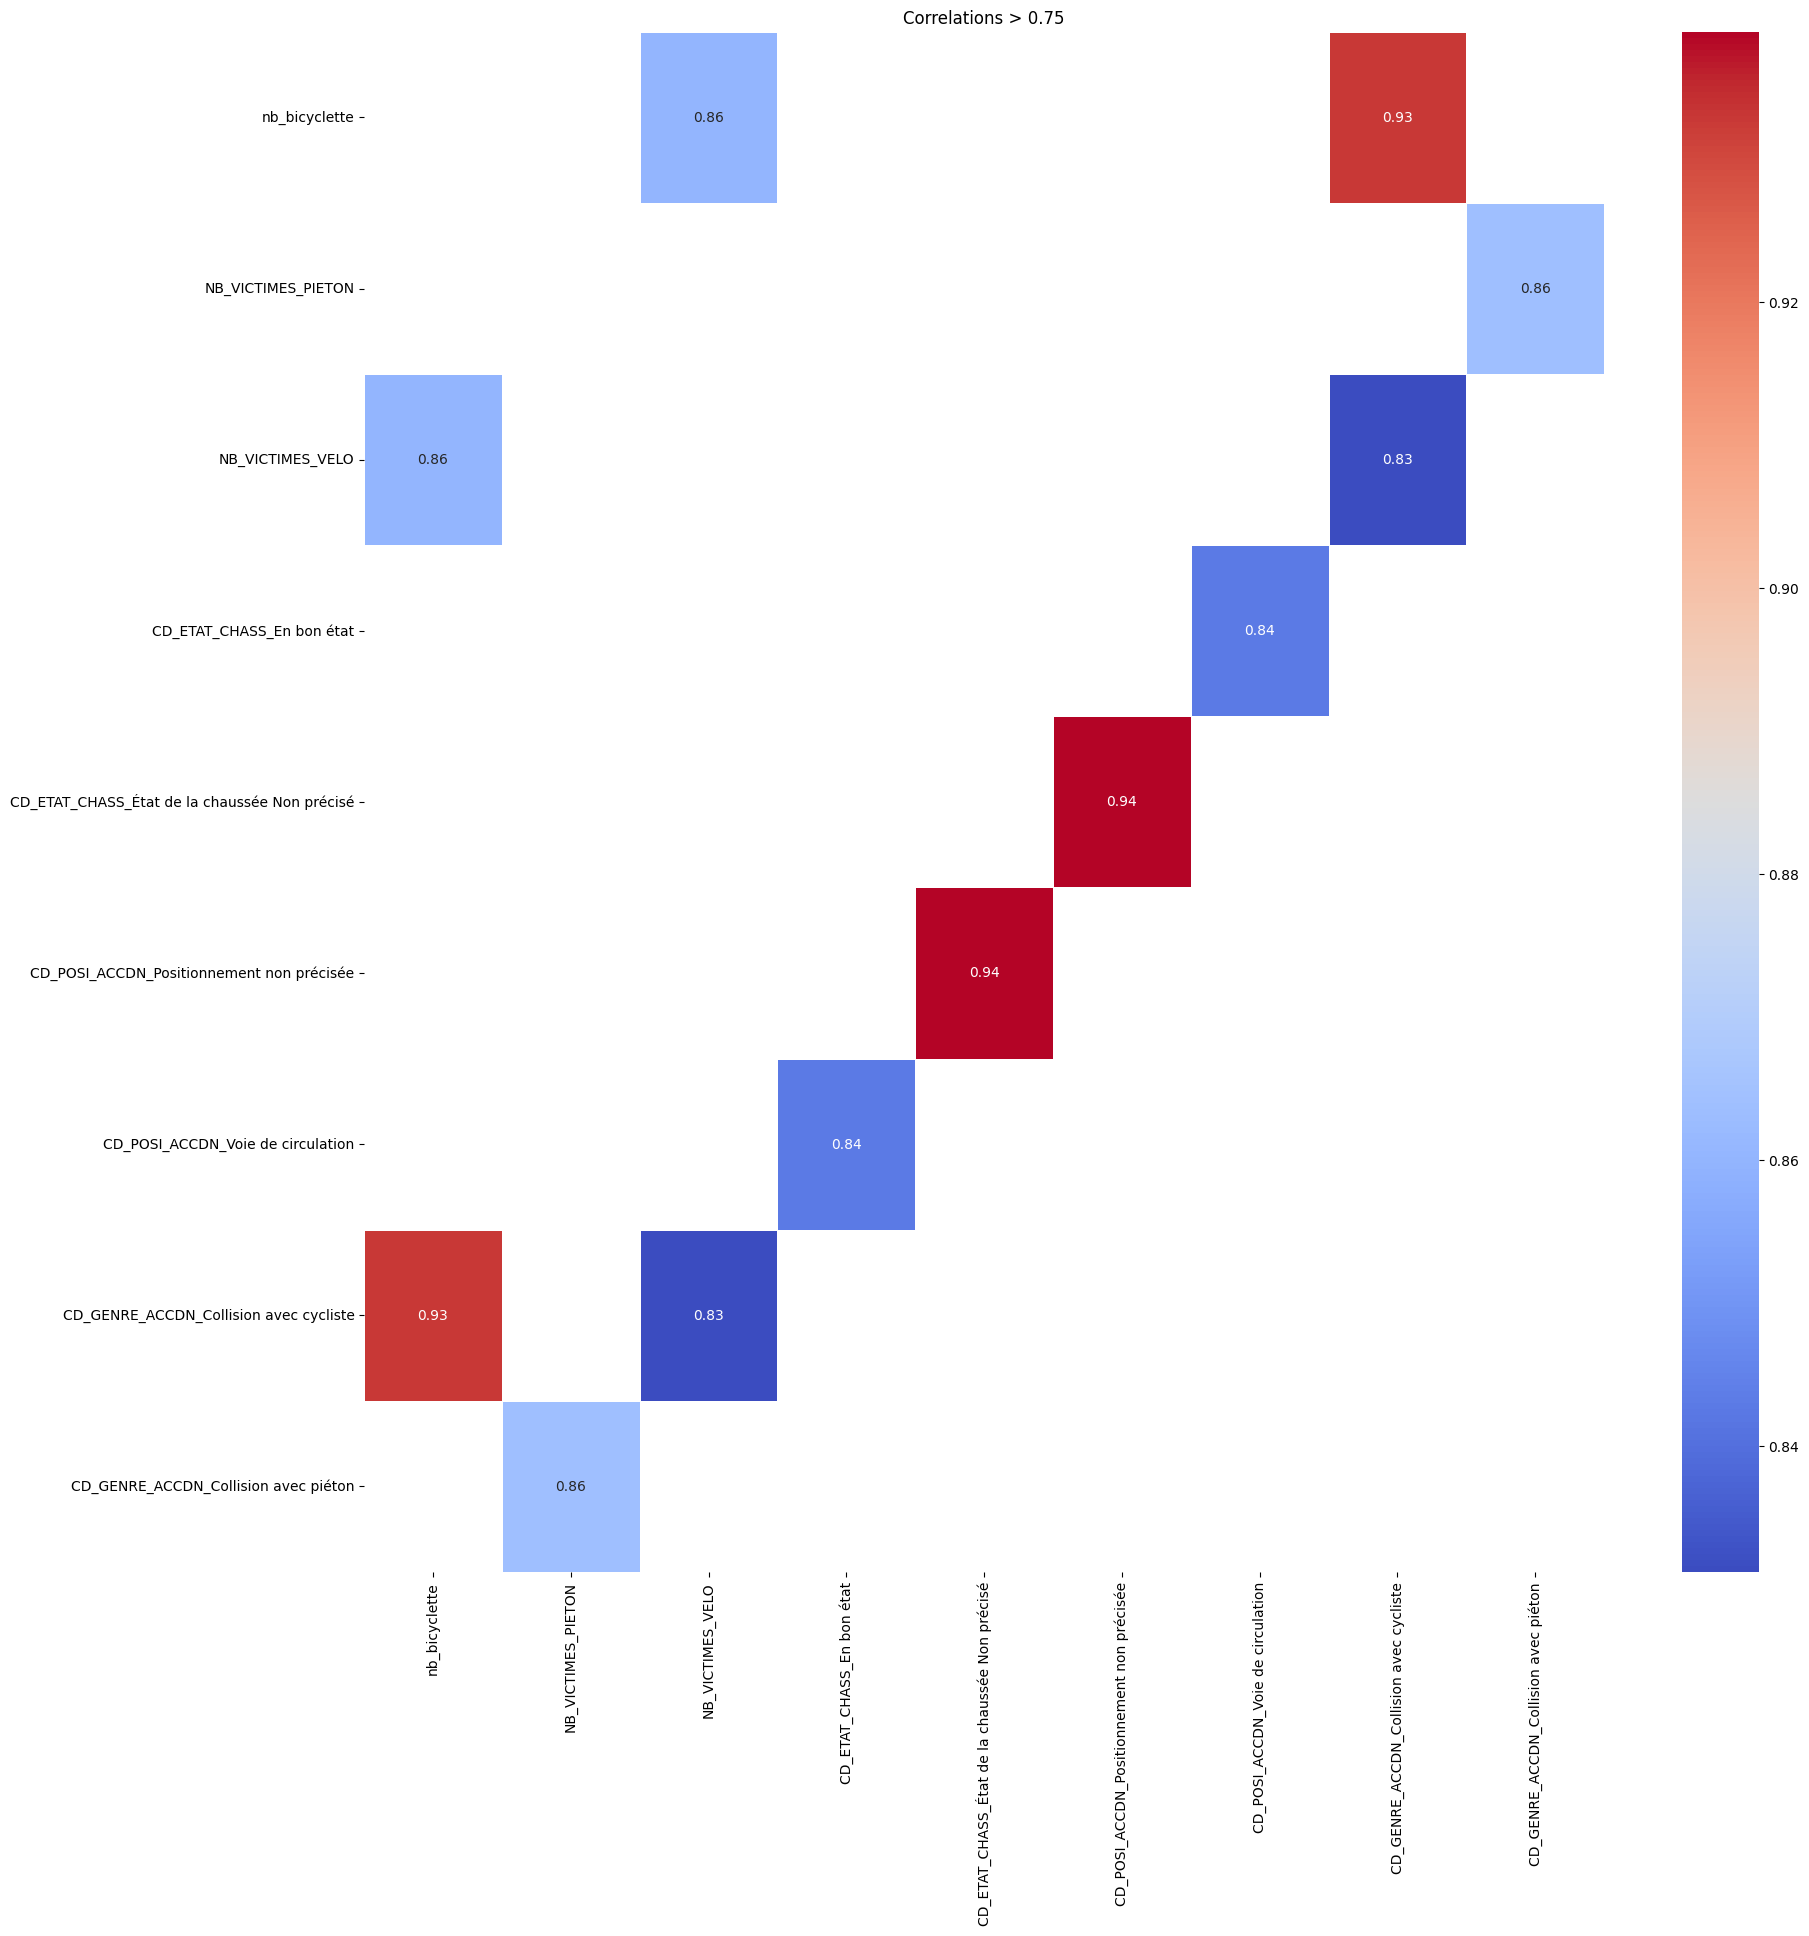

In [39]:
# Compute correlation matrix
corr_matrix = df.corr()

# Get correlations above 0.5 (excluding self-correlations)
high_corr = corr_matrix[(corr_matrix > 0.75) & (corr_matrix < 1.0)]

# Display only non-null values
high_corr.dropna(how="all", inplace=True)
high_corr.dropna(how="all", inplace=True)
high_corr.dropna(axis=1, how="all", inplace=True)

# Visualizing the filtered correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(high_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlations > 0.75")
plt.show()

In [41]:
 # Select first 100 rows by position
first_100 = df.iloc[:100] 
first_100.to_csv('first_100_rows.csv', index=False)

Series([], dtype: int64)


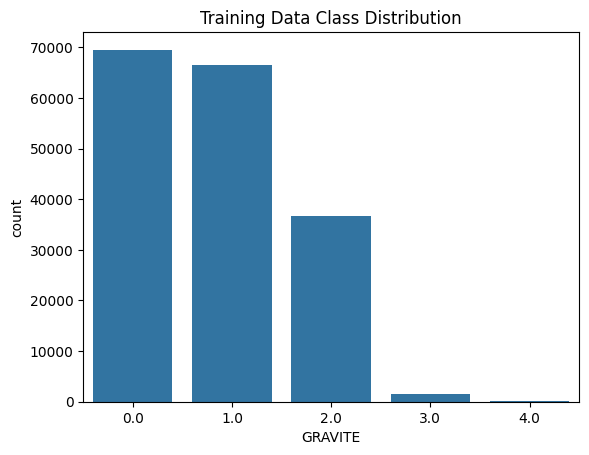

In [43]:
# Make a deep copy of the original DataFrame to preserve it for future reference
df_copy = df.copy()

# Separate the input features (X) from the target variable (y)
X = df.drop(columns=['GRAVITE'])  # X: all columns except the target 'GRAVITE'
y = df['GRAVITE']                 # y: the target column representing accident severity

# Split the dataset into training and testing subsets
# 80% of the data is used for training, 20% for testing
# random_state=42 ensures the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Check for missing values in the training features
# .isnull().sum() returns the number of missing values per column
missing_train = X_train.isnull().sum()
# Keep only columns that have one or more missing values
missing_train = missing_train[missing_train > 0]
# Print the result; an empty Series means there are no missing values
print(missing_train)  # Should be empty if the training data has no nulls

# Visualize the distribution of classes in the training target
import matplotlib.pyplot as plt  # Core plotting library
import seaborn as sns            # Statistical visualization library

# Create a count plot showing the frequency of each severity class in y_train
sns.countplot(x=y_train)
# Add a title for clarity
plt.title("Training Data Class Distribution")
# Display the plot window
plt.show()

## Model training and comparison

In [46]:
# Import various classifier implementations and evaluation metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support
)
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from imblearn.over_sampling import SMOTE
# Import and prepare sample weights to handle class imbalance
from sklearn.utils.class_weight import compute_sample_weight

# Define a dictionary of model names(DecisionTree, RandomForest, XGBoost) to their instantiated classifier objects
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

# Loop through each model in the dictionary to train and evaluate
for name, model in models.items():
    print(f"\n🔍 Training: {name}")

    # Train the classifier on the training data
    model.fit(X_train, y_train)

    # Generate predictions on the test set
    y_pred = model.predict(X_test)

    # Display a detailed classification report (precision, recall, f1-score)
    print(f"✅ Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Display the confusion matrix showing true vs. predicted labels
    print("🧩 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

# Finally, print out the overall accuracy of each model for quick comparison
for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")



🔍 Training: Decision Tree
✅ Classification Report for Decision Tree:

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60     17472
         1.0       0.58      0.58      0.58     16624
         2.0       0.96      0.95      0.96      9133
         3.0       0.05      0.06      0.06       351
         4.0       0.00      0.00      0.00        46

    accuracy                           0.66     43626
   macro avg       0.44      0.44      0.44     43626
weighted avg       0.66      0.66      0.66     43626

🧩 Confusion Matrix:
[[10424  7048     0     0     0]
 [ 6937  9687     0     0     0]
 [    0     0  8699   371    63]
 [    0     0   324    21     6]
 [    0     0    42     4     0]]

🔍 Training: Random Forest
✅ Classification Report for Random Forest:

              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     17472
         1.0       0.66      0.62      0.64     16624
         2.0       0

In [47]:
# compute_sample_weight assigns a weight to each sample inversely proportional to its class frequency (to solve the imbalancy issue)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize the XGBoost model with fixed random state for reproducibility
# use_label_encoder=False and eval_metric='mlogloss' disable the legacy label encoder and set the multiclass loss
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model on the training data, passing in sample_weight to emphasize minority classes
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Import evaluation utilities
from sklearn.metrics import classification_report, confusion_matrix

# Display precision, recall, F1-score for each class
print(classification_report(y_test, y_pred))

# Display the confusion matrix to show true vs. predicted class counts
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68     17472
         1.0       0.66      0.65      0.66     16624
         2.0       0.98      0.77      0.86      9133
         3.0       0.08      0.44      0.13       351
         4.0       0.04      0.28      0.07        46

    accuracy                           0.69     43626
   macro avg       0.49      0.57      0.48     43626
weighted avg       0.73      0.69      0.70     43626

[[12059  5413     0     0     0]
 [ 5884 10740     0     0     0]
 [    0     0  7053  1794   286]
 [    0     0   156   153    42]
 [    0     0    20    13    13]]


In [48]:
# Merge rare classes in the copied version (class 3 and 4)
df_copy['GRAVITE'] = df_copy['GRAVITE'].replace({4.0: 3.0})

# Merge the rare class 4.0 into class 3.0
df_copy['GRAVITE'] = df_copy['GRAVITE'].replace({4.0: 3.0})
print(df_copy['GRAVITE'].value_counts())  # Check that class 4.0 is gone

# Split features and target
X = df_copy.drop(columns=['GRAVITE'])
y = df_copy['GRAVITE']

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GRAVITE
0.0    87013
1.0    83171
2.0    45897
3.0     2047
Name: count, dtype: int64


In [52]:
# compute_sample_weightwith XGBoost model and mixing class 3 and 4
# compute_sample_weight assigns a weight to each sample inversely proportional to its class frequency (to solve the imbalancy issue)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize the XGBoost model with fixed random state for reproducibility
# use_label_encoder=False and eval_metric='mlogloss' disable the legacy label encoder and set the multiclass loss
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model on the training data, passing in sample_weight to emphasize minority classes
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict the labels of the test set
y_pred = model.predict(X_test)

# Display precision, recall, F1-score for each class
print(classification_report(y_test, y_pred))

# Display the confusion matrix to show true vs. predicted class counts
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68     17472
         1.0       0.66      0.65      0.66     16624
         2.0       0.97      0.79      0.87      9133
         3.0       0.10      0.53      0.17       397

    accuracy                           0.69     43626
   macro avg       0.60      0.66      0.59     43626
weighted avg       0.73      0.69      0.71     43626

[[12012  5460     0     0]
 [ 5860 10764     0     0]
 [    0     0  7195  1938]
 [    0     0   186   211]]


In [53]:
# Models with class weights BalanceRandomForest, DecisicionTree with Balance and XGBoostClassifier with SoftProbability
# This block defines three multiclass classifiers—Decision Tree and Balanced Random Forest with built-in class weighting,
# and an XGBoost classifier configured for soft-probability outputs after merging the two rarest classes into one.
# It then iterates over each model, fits it on the training data, makes predictions on the test set, and prints
# a classification report, confusion matrix, and overall accuracy for each.

# Models with class weights: DecisionTreeClassifier (balanced), BalancedRandomForestClassifier, and XGBClassifier
model = {
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),      # Tree with balanced class weights
    "Random Forest": BalancedRandomForestClassifier(n_estimators=100, random_state=42),      # Ensemble with balanced sampling
    "xgb_mode": XGBClassifier(
        objective='multi:softprob',  # Output class probabilities (for multiclass tasks)
        num_class=4,                 # We have 4 classes after merging rare levels
        eval_metric='mlogloss',      # Multiclass log loss evaluation metric
        random_state=42              # Seed for reproducibility
    )
}

# Loop through each named model in the dictionary
for name, model in models.items():
    print(f"\n📌 Training: {name}")  # Announce which model is being trained

    # Fit the current model on the training data (with class weighting or resampling applied earlier)
    model.fit(X_train, y_train)    # NOTE: uses the 'models' dict instead of 'model'; ensures training occurs

    # Generate predictions on the unseen test set
    y_pred = model.predict(X_test)

    # Print out a detailed classification report: precision, recall, F1-score per class
    print(f"\n✅ Classification Report for {name}:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Print the confusion matrix to inspect true vs. predicted class assignments
    print("📊 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Finally, display the overall accuracy score for quick comparison
    print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred):.4f}")


📌 Training: Decision Tree

✅ Classification Report for Decision Tree:

              precision    recall  f1-score   support

         0.0       0.60      0.60      0.60     17472
         1.0       0.58      0.58      0.58     16624
         2.0       0.96      0.95      0.96      9133
         3.0       0.09      0.12      0.10       397

    accuracy                           0.66     43626
   macro avg       0.56      0.56      0.56     43626
weighted avg       0.66      0.66      0.66     43626

📊 Confusion Matrix:
[[10424  7048     0     0]
 [ 6937  9687     0     0]
 [    0     0  8681   452]
 [    0     0   350    47]]
🎯 Accuracy: 0.6611

📌 Training: Random Forest

✅ Classification Report for Random Forest:

              precision    recall  f1-score   support

         0.0       0.66      0.69      0.67     17472
         1.0       0.66      0.62      0.64     16624
         2.0       0.96      1.00      0.98      9133
         3.0       0.12      0.00      0.00       397

 

## Imbalance classes handling 

In [55]:
# This code computes balanced sample weights, trains an XGBoost classifier with those weights to counter class imbalance,
# applies a custom probability threshold to boost detection of class 3 accidents, and evaluates the thresholded predictions.
# Weighted Gboost
# Import and prepare sample weights for balanced classes
from sklearn.utils.class_weight import compute_sample_weight

# Compute per-sample weights inversely proportional to class frequencies in y_train
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Initialize XGBoost classifier with multiclass log loss
model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model on the training set, using sample_weight to emphasize minority classes
model.fit(X_train, y_train, sample_weight=sample_weights)

# Predict class probabilities on the test set
y_proba = model.predict_proba(X_test)

# Set a custom decision threshold for predicting class 3
threshold_class3 = 0.2

# Generate custom predictions: if class 3 probability >= threshold, predict 3; otherwise pick the highest-probability class

y_pred_custom = []

for i in range(len(y_proba)):
    if y_proba[i][3] >= threshold_class3:
        y_pred_custom.append(3)
    else:
        y_pred_custom.append(np.argmax(y_proba[i]))

# Evaluate the custom predictions with a classification report and confusion matrix
print("🔍 Classification Report with Custom Threshold for Class 3:")
print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))


🔍 Classification Report with Custom Threshold for Class 3:
              precision    recall  f1-score   support

         0.0       0.67      0.69      0.68     17472
         1.0       0.66      0.65      0.66     16624
         2.0       0.98      0.45      0.62      9133
         3.0       0.06      0.84      0.12       397

    accuracy                           0.62     43626
   macro avg       0.60      0.66      0.52     43626
weighted avg       0.73      0.62      0.65     43626

[[12012  5460     0     0]
 [ 5860 10764     0     0]
 [    0     0  4102  5031]
 [    0     0    63   334]]


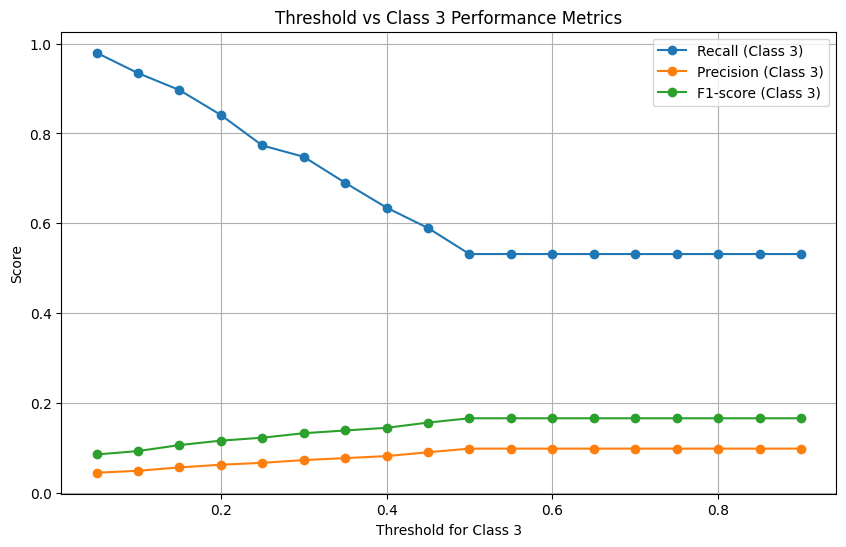

In [56]:
# Get probabilities
y_proba = model.predict_proba(X_test)

# Store results
thresholds = np.arange(0.05, 0.91, 0.05)
recalls = []
precisions = []
f1s = []

for thresh in thresholds:
    y_pred_custom = []
    for i in range(len(y_proba)):
        if y_proba[i][3] >= thresh:
            y_pred_custom.append(3)
        else:
            y_pred_custom.append(np.argmax(y_proba[i]))

    # Focus only on class 3
    recall = recall_score(y_test, y_pred_custom, labels=[3], average='macro')
    precision = precision_score(y_test, y_pred_custom, labels=[3], average='macro')
    f1 = f1_score(y_test, y_pred_custom, labels=[3], average='macro')

    recalls.append(recall)
    precisions.append(precision)
    f1s.append(f1)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall (Class 3)', marker='o')
plt.plot(thresholds, precisions, label='Precision (Class 3)', marker='o')
plt.plot(thresholds, f1s, label='F1-score (Class 3)', marker='o')
plt.xlabel('Threshold for Class 3')
plt.ylabel('Score')
plt.title('Threshold vs Class 3 Performance Metrics')
plt.legend()
plt.grid(True)
plt.show()


## Final Model Evaluation

After selecting the model and decision threshold using cross-validation,
the final evaluation was performed on a held-out test set.
Performance is reported using precision, recall, and F1-score,
with particular attention to severe accident classes.

In [64]:
# This script evaluates how different probability thresholds for class 3 affect model performance.
# It performs a 5-fold stratified cross-validation, applies SMOTE on each training split,
# trains an XGBoost model, applies custom thresholding for class 3, computes precision/recall/F1/accuracy,
# aggregates results across folds, prints detailed metrics, and finally plots threshold vs. scores.

# 📌 Thresholds you want to test
thresholds = [0.01, 0.02, 0.05, 0.10]

# 📌 Storage for plotting
recalls_class3, precisions_class3, f1s_class3, accuracies = [], [], [], []

# 📌 Setup Stratified KFold for 5 splits, ensuring balanced class distribution in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Loop over each threshold to evaluate its impact
for thresh in thresholds:
    print(f"\n🔵 Threshold {thresh:.2f}")

    # Initialize storage for this threshold
    fold_accuracies = []
    fold_precisions = {c: [] for c in [0,1,2,3]}      # per-class precision lists
    fold_recalls    = {c: [] for c in [0,1,2,3]}      # per-class recall lists
    fold_f1s        = {c: [] for c in [0,1,2,3]}      # per-class F1-score lists
    fold_conf_matrices = []                          # store confusion matrices

    # Perform stratified cross-validation
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        # ✅ Correct slicing with .iloc for pandas DataFrame/Series
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Apply SMOTE on training split to balance classes
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

        # Train XGBoost on the resampled data
        model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        model.fit(X_train_res, y_train_res)

        # Predict class probabilities on the test split
        y_proba = model.predict_proba(X_test)

        # Custom prediction: if prob of class 3 ≥ threshold, choose class 3; otherwise pick argmax
        y_pred_custom = [
            3 if probs[3] >= thresh else np.argmax(probs)
            for probs in y_proba
        ]

        # Compute precision, recall, F1-score for all classes [0,1,2,3]
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_custom, labels=[0,1,2,3], zero_division=0
        )
        # Compute overall accuracy
        acc = accuracy_score(y_test, y_pred_custom)

        # Store fold metrics
        fold_accuracies.append(acc)
        for c in [0,1,2,3]:
            fold_precisions[c].append(precision[c])
            fold_recalls[c].append(recall[c])
            fold_f1s[c].append(f1[c])

        # Store the confusion matrix for this fold
        cm = confusion_matrix(y_test, y_pred_custom, labels=[0,1,2,3])
        fold_conf_matrices.append(cm)

        # 🖨️ Print fold-level metrics
        print(f"  Fold {fold} - Accuracy: {acc:.3f}")
        for c in [0,1,2,3]:
            print(f"    Class {c}: Precision={precision[c]:.3f} | Recall={recall[c]:.3f} | F1={f1[c]:.3f}")

    # After all folds, compute average metrics for this threshold
    avg_accuracy     = np.mean(fold_accuracies)
    avg_prec3, avg_rec3, avg_f13 = (
        np.mean(fold_precisions[3]),
        np.mean(fold_recalls[3]),
        np.mean(fold_f1s[3])
    )

    # 📋 Print average metrics
    print(f"\n✅ Average for Threshold {thresh:.2f}:")
    print(f"  Accuracy: {avg_accuracy:.3f}")
    for c in [0,1,2,3]:
        print(f"  Class {c}: "
              f"Avg Precision={np.mean(fold_precisions[c]):.3f} | "
              f"Avg Recall={np.mean(fold_recalls[c]):.3f} | "
              f"Avg F1={np.mean(fold_f1s[c]):.3f}")

    # Save averages for plotting
    accuracies.append(avg_accuracy)
    recalls_class3.append(avg_rec3)
    precisions_class3.append(avg_prec3)
    f1s_class3.append(avg_f13)

    # 🟢 Compute & display the average confusion matrix across folds
    avg_cm = np.mean(fold_conf_matrices, axis=0)
    avg_cm_df = pd.DataFrame(
        avg_cm,
        index=[f"True {c}" for c in [0,1,2,3]],
        columns=[f"Pred {c}" for c in [0,1,2,3]]
    )
    print(f"\n🟢 Average Confusion Matrix for Threshold {thresh:.2f}:")
    print(avg_cm_df)


🔵 Threshold 0.01
  Fold 1 - Accuracy: 0.579
    Class 0: Precision=0.668 | Recall=0.704 | F1=0.686
    Class 1: Precision=0.672 | Recall=0.634 | F1=0.652
    Class 2: Precision=0.985 | Recall=0.229 | F1=0.371
    Class 3: Precision=0.050 | Recall=0.919 | F1=0.096
  Fold 2 - Accuracy: 0.579
    Class 0: Precision=0.670 | Recall=0.709 | F1=0.689
    Class 1: Precision=0.676 | Recall=0.635 | F1=0.655
    Class 2: Precision=0.987 | Recall=0.216 | F1=0.355
    Class 3: Precision=0.051 | Recall=0.937 | F1=0.096
  Fold 3 - Accuracy: 0.582
    Class 0: Precision=0.669 | Recall=0.708 | F1=0.688
    Class 1: Precision=0.675 | Recall=0.634 | F1=0.654
    Class 2: Precision=0.981 | Recall=0.234 | F1=0.378
    Class 3: Precision=0.050 | Recall=0.900 | F1=0.094
  Fold 4 - Accuracy: 0.582
    Class 0: Precision=0.667 | Recall=0.700 | F1=0.683
    Class 1: Precision=0.669 | Recall=0.634 | F1=0.651
    Class 2: Precision=0.985 | Recall=0.250 | F1=0.399
    Class 3: Precision=0.052 | Recall=0.914 | F1=

### Threshold selection

As the decision threshold for class 3 increases, recall decreases while precision
and overall accuracy improve. This highlights a clear trade-off between detecting
severe accidents and maintaining global performance.

A threshold of **0.05** was selected as it provides a balanced compromise:
- Recall remains reasonably high for severe accidents
- Precision improves compared to lower thresholds
- Overall accuracy is not significantly degraded

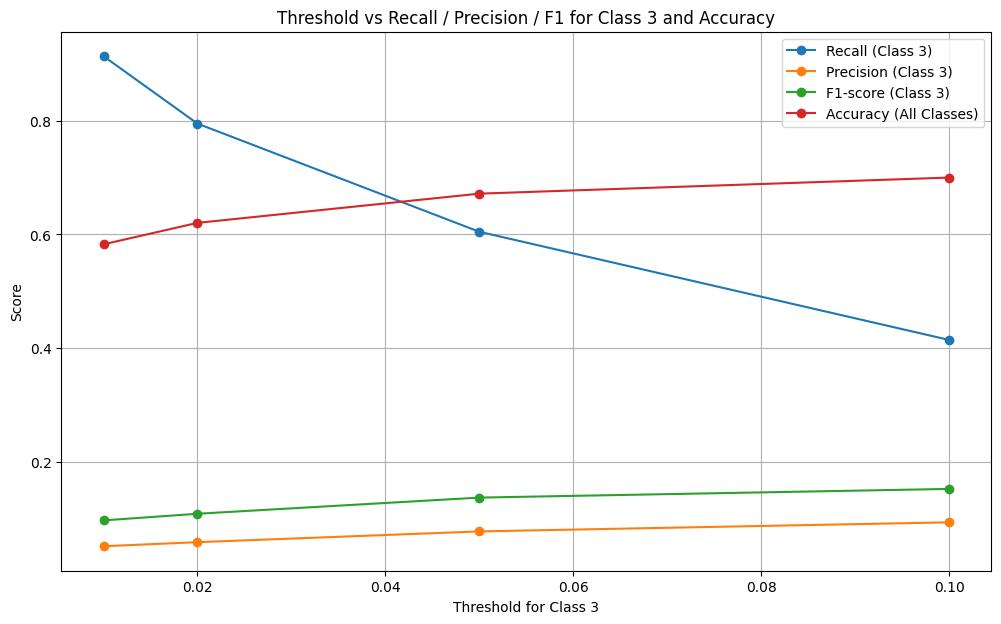

In [65]:
# 📈 Finally, plot how threshold impacts class-3 metrics and overall accuracy
plt.figure(figsize=(12, 7))
plt.plot(thresholds, recalls_class3, label='Recall (Class 3)', marker='o')
plt.plot(thresholds, precisions_class3, label='Precision (Class 3)', marker='o')
plt.plot(thresholds, f1s_class3, label='F1-score (Class 3)', marker='o')
plt.plot(thresholds, accuracies, label='Accuracy (All Classes)', marker='o')
plt.xlabel('Threshold for Class 3')
plt.ylabel('Score')
plt.title('Threshold vs Recall / Precision / F1 for Class 3 and Accuracy')
plt.grid(True)
plt.legend()
plt.show()

## Conclusion

Severe accident prediction is limited by strong class imbalance. Threshold tuning improves detection of rare severe cases but introduces a clear precision–recall trade-off, confirming that accuracy alone is not sufficient for evaluation.